# Using Lz and Lxy

The BDT predictive variable Lz and Lxy need to be built into the BDT. They have already been included, and Lxy has been shown to be useful. Lz, however, not so much - it gets dropped when we do variable elimination.

Here we will look at:
- General Characterists of Lx and Lxy to see how they might help us
  - General plot of Lz and Lxy
  - Explore how their effectiveness varies as a function of eta and anything else that seems relevent
- How does a cut on Lxy and Lz affect the training?

## Initalization

In [2]:
from bdt_training_scikit_tools import plot_training_performance, load_default_samples, \
    test_train_samples, prep_samples, default_training, calc_performance, calc_performance_for_run, \
    default_training_variable_list
import matplotlib.pyplot as plt
plt.rc('font', size=14)
from matplotlib.colors import LogNorm
import pandas as pd
import numpy as np
import multiprocessing as mp

## Load Data Samples

In [3]:
all_events = load_default_samples("92")

BIB: 800000 events
Multijet: 800000 events
Signal: 800000 events


In [4]:
signal = all_events[2]

In [5]:
signal.columns

Index(['RunNumber', 'Weight', 'WeightMCEvent', 'WeightXSection',
       'WeightFlatten', 'mc_Lxy', 'mc_Lz', 'MHTOverHT', 'JetPt', 'JetPhi',
       'CalRatio', 'JetEta', 'NTracks', 'SumPtOfAllTracks', 'MaxTrackPt',
       'EventNumber', 'JetET', 'JetWidth', 'JetDRTo2GeVTrack', 'EnergyDensity',
       'HadronicLayer1Fraction', 'JetLat', 'JetLong', 'FirstClusterRadius',
       'ShowerCenter', 'BIBDeltaTimingM', 'BIBDeltaTimingP', 'PredictedLz',
       'PredictedLxy', 'InteractionsPerCrossing'],
      dtype='object')

## Basic Plots

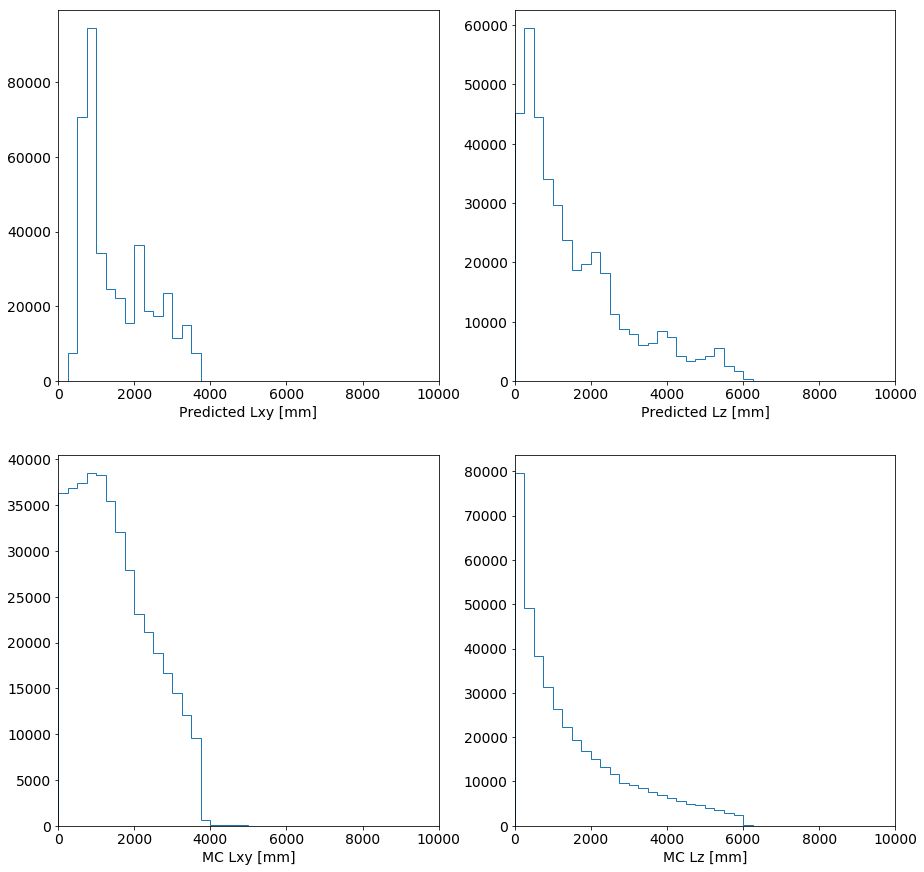

In [5]:
fig = plt.figure(figsize=(15,15))

histargs = {'bins': 40, 'histtype': 'step', 'range': (0, 10000)}

ax = plt.subplot(221)
ax.hist(signal.PredictedLxy, **histargs)
ax.set_xlabel('Predicted Lxy [mm]')
ax.set_xlim(0.0, 10000)

ax = plt.subplot(222)
ax.hist(signal.PredictedLz, **histargs)
ax.set_xlabel('Predicted Lz [mm]')
ax.set_xlim(0.0, 10000)

ax = plt.subplot(223)
ax.hist(signal.mc_Lxy*1000, **histargs)
ax.set_xlabel('MC Lxy [mm]')
ax.set_xlim(0.0, 10000)

ax = plt.subplot(224)
ax.hist(signal.mc_Lz*1000, **histargs)
ax.set_xlabel('MC Lz [mm]')
ax.set_xlim(0.0, 10000)

plt.show()
fig.savefig('basicplots.png')

Clearly, there are some major discrpencies. Explore things like $\eta$ and the like.

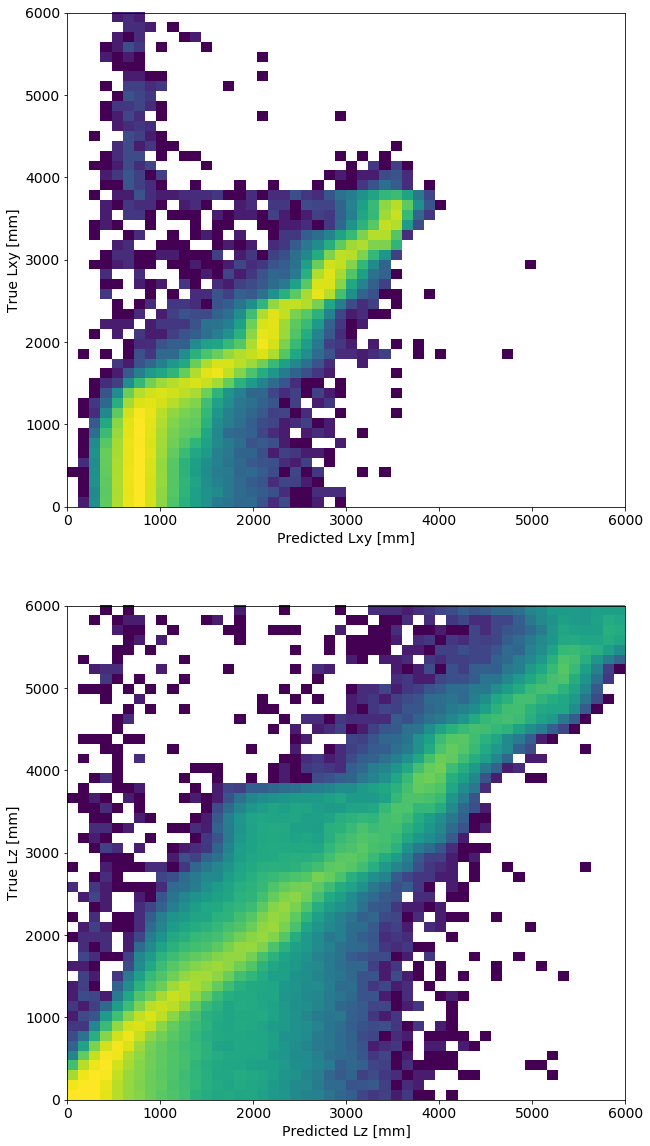

In [18]:
fig = plt.figure(figsize=(10,20))

histargs2d = {'bins':50, 'norm':LogNorm(), 'range': ((0, 6000), (0, 6000))}
ax = plt.subplot(211)
ax.hist2d(signal.PredictedLxy, signal.mc_Lxy*1000, **histargs2d)
ax.set_xlabel('Predicted Lxy [mm]')
ax.set_ylabel('True Lxy [mm]')

ax = plt.subplot(212)
ax.hist2d(signal.PredictedLz, signal.mc_Lz*1000, **histargs2d)
ax.set_xlabel('Predicted Lz [mm]')
ax.set_ylabel('True Lz [mm]')

plt.show()
fig.savefig('lxylz_comparisons.png')

Look at things as a function of distance from their actual value - see if there is a correlation with $\eta$, for example.

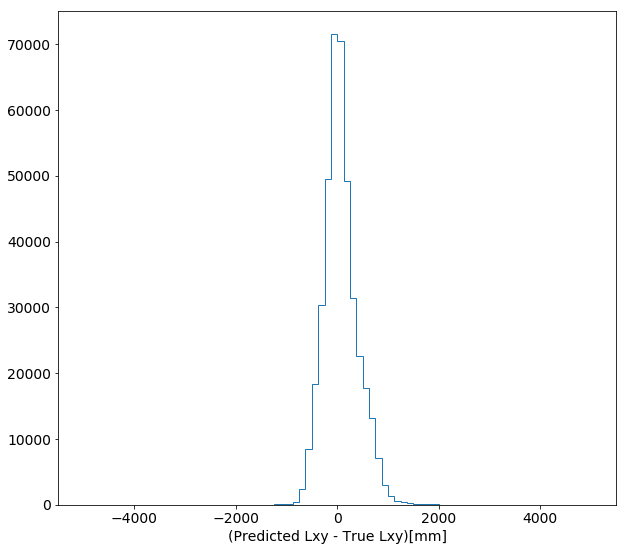

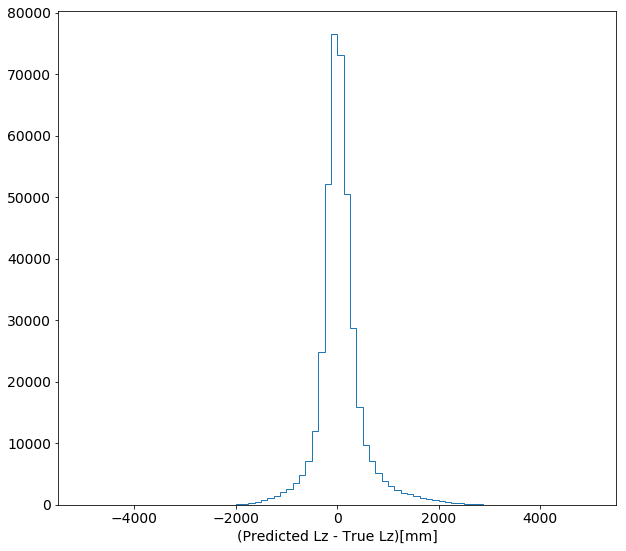

In [7]:
delta_Lxy = signal.PredictedLxy - signal.mc_Lxy*1000
delta_Lz = signal.PredictedLz - signal.mc_Lz*1000

histargs = {'bins': 80, 'histtype': 'step', 'range': (-5000, 5000)}

fig = plt.figure(figsize=(10,20))
ax = plt.subplot(211)
ax.hist(delta_Lxy, **histargs)
ax.set_xlabel('(Predicted Lxy - True Lxy)[mm]')

fig = plt.figure(figsize=(10,20))
ax = plt.subplot(212)
ax.hist(delta_Lz, **histargs)
ax.set_xlabel('(Predicted Lz - True Lz)[mm]')

plt.show()
fig.savefig('lxylz_1dComparison.png')

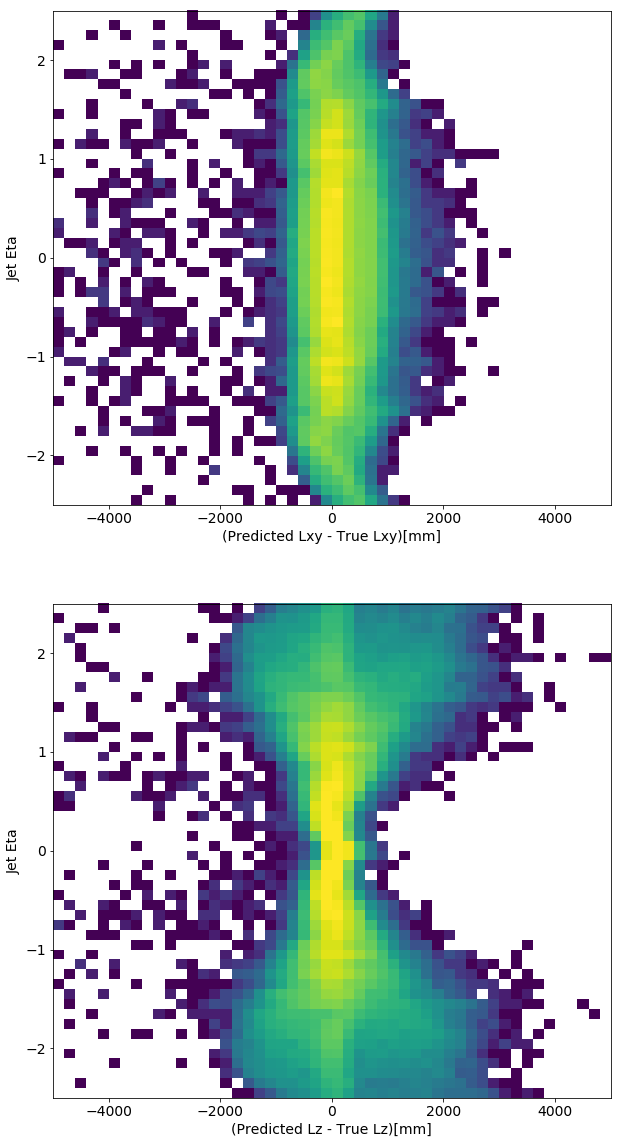

In [8]:
fig = plt.figure(figsize=(10,20))

histargs2d = {'bins':50, 'norm':LogNorm(), 'range': ((-5000, 5000), (-2.5, 2.5))}
ax = plt.subplot(211)
ax.hist2d(delta_Lxy, signal.JetEta, **histargs2d)
ax.set_xlabel('(Predicted Lxy - True Lxy)[mm]')
ax.set_ylabel('Jet Eta')

ax = plt.subplot(212)
ax.hist2d(delta_Lz, signal.JetEta, **histargs2d)
ax.set_xlabel('(Predicted Lz - True Lz)[mm]')
ax.set_ylabel('Jet Eta')

plt.show()
fig.savefig('lxylz_ComparisonVsEta.png')

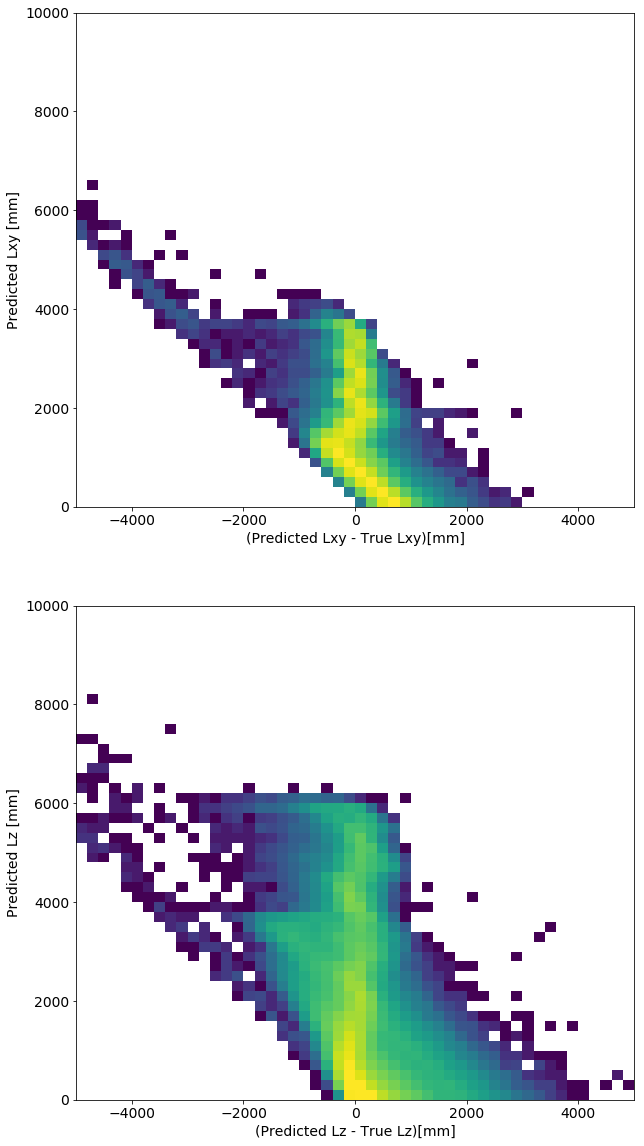

In [9]:
fig = plt.figure(figsize=(10,20))

histargs2d = {'bins':50, 'norm':LogNorm(), 'range': ((-5000, 5000), (0, 10000))}
ax = plt.subplot(211)
ax.hist2d(delta_Lxy, signal.mc_Lxy*1000.0, **histargs2d)
ax.set_xlabel('(Predicted Lxy - True Lxy)[mm]')
ax.set_ylabel('Predicted Lxy [mm]')

ax = plt.subplot(212)
ax.hist2d(delta_Lz, signal.mc_Lz*1000.0, **histargs2d)
ax.set_xlabel('(Predicted Lz - True Lz)[mm]')
ax.set_ylabel('Predicted Lz [mm]')

plt.show()
fig.savefig('lxylz_PredictionVsAccuracy.png')

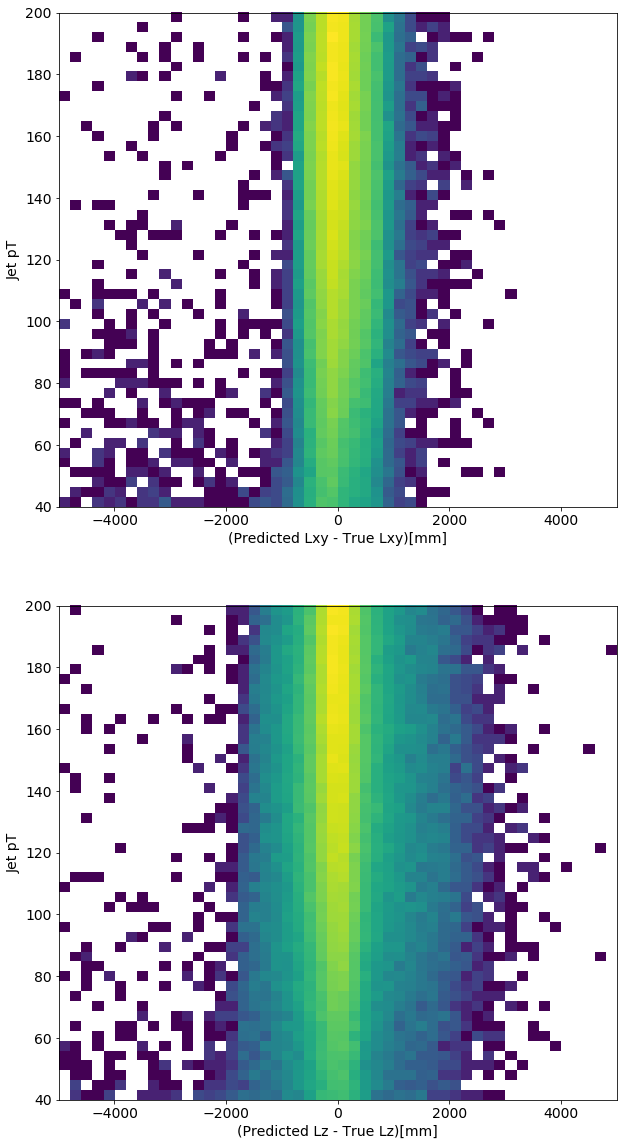

In [10]:
fig = plt.figure(figsize=(10,20))

histargs2d = {'bins':50, 'norm':LogNorm(), 'range': ((-5000, 5000), (40, 200.0))}
ax = plt.subplot(211)
ax.hist2d(delta_Lxy, signal.JetPt, **histargs2d)
ax.set_xlabel('(Predicted Lxy - True Lxy)[mm]')
ax.set_ylabel('Jet pT')

ax = plt.subplot(212)
ax.hist2d(delta_Lz, signal.JetPt, **histargs2d)
ax.set_xlabel('(Predicted Lz - True Lz)[mm]')
ax.set_ylabel('Jet pT')

plt.show()

## Cuts on Lxy and Lz during training
There is evidence that the training is having trouble telling the difference between QCD jets and short-range Lxy and Lz jets... So the question is - what if we trim down on the number of short IP jets in the training?

First thing to be aware here is that we have to split things by eta when we look at them.

In [6]:
forward_eta_cut = 1.4
signal_forward = signal[abs(signal.JetEta)>forward_eta_cut]
signal_central = signal[abs(signal.JetEta)<=forward_eta_cut]

K:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


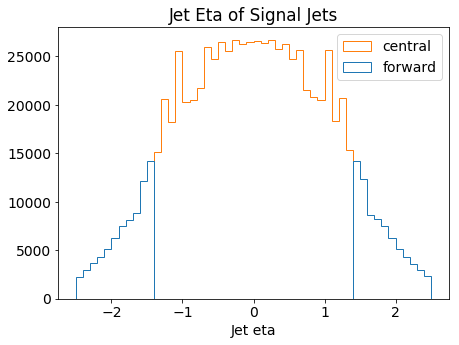

In [6]:
fig = plt.figure(figsize=(7,5))
ax = plt.subplot(111)
ax.hist([signal_forward.JetEta, signal_central.JetEta], bins=50, histtype='step', label=['forward', 'central'])
ax.set_xlabel('Jet eta')
ax.set_title('Jet Eta of Signal Jets')
ax.legend()

plt.show()

Where is a good place to make a cut? For this the real question is as Lxy increasee in the central region, where does the MLP prediction start to pick things up? This is probably the most senstive thing to look at to determine this.

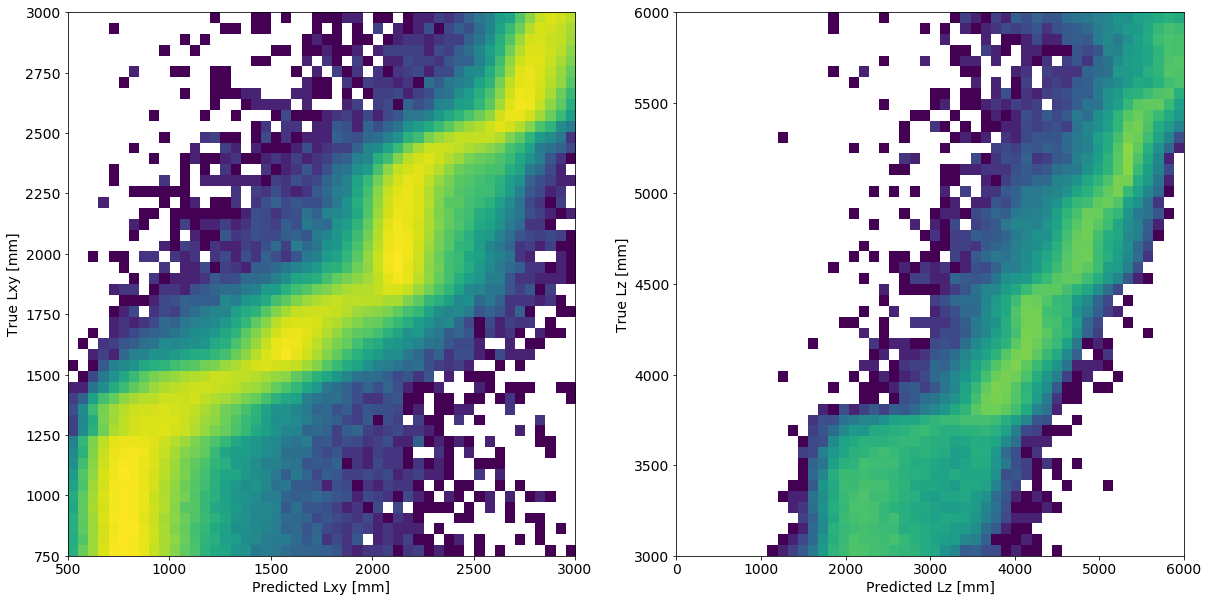

In [7]:
fig = plt.figure(figsize=(20,10))

histargs2d = {'bins':50, 'norm':LogNorm()}
ax = plt.subplot(121)
ax.hist2d(signal_central.PredictedLxy, signal_central.mc_Lxy*1000, range=((500, 3000), (750, 3000)), **histargs2d)
ax.set_xlabel('Predicted Lxy [mm]')
ax.set_ylabel('True Lxy [mm]')

ax = plt.subplot(122)
ax.hist2d(signal_forward.PredictedLz, signal_forward.mc_Lz*1000, range=((0, 6000), (3000, 6000)), **histargs2d)
ax.set_xlabel('Predicted Lz [mm]')
ax.set_ylabel('True Lz [mm]')

plt.show()

In conclusion:

- Lxy: looks like the first evidence of something changing happens at 1250 - there is almost a sharp break. Lets guess around 1000 mm to be safe and see what happens.
- Lx: Around 3750 mm seems to be the break. So, to be safe lets put it at 3500.

In [7]:
cut_lxy = 1250
cut_lz = 3500

In [8]:
def signal_with_dl_cut (signal, cut_lxy, cut_lz, eta_seperator_cut = 1.4):
    '''Return the signal with a decay length cut applied for central and forward regions.
    
    Args:
        signal - the pandas DF that contains our standard signal
        cut_lxy - where we want to make the lxy cut in the central jets. Jets with something shorter won't be here. [mm]
        cut_lz - where we want to make the lz cut for forward jets. [mm]
        eta_seperator_cut - how to tell the diference between central and forward regions.
        
    Returns:
        sig - A signal DF with the cuts applied
    
    '''
    return signal[((abs(signal.JetEta) > eta_seperator_cut) & (signal.mc_Lz*1000 > cut_lz)) | ((abs(signal.JetEta) <= eta_seperator_cut) & (signal.mc_Lxy*1000 > cut_lxy))]
    #fwd_jets = signal[abs(signal.JetEta) > eta_seperator_cut]
    #cen_jets = signal[abs(signal.JetEta) <= eta_seperator_cut]
    
    #good_fwd_jets = fwd_jets[fwd_jets.mc_Lz*1000 > cut_lz]
    #good_cen_jets = cen_jets[cen_jets.mc_Lxy*1000 > cut_lxy]


In [9]:
signal_default_cut = signal_with_dl_cut(signal, cut_lxy, cut_lz)
print (len(signal_default_cut))

432189


Given this sample, run the training and evaulation and look at the result for both skimmed and unskimmed. Our figure of merit is going to have to do with how we calculate bib. So, we'll do the standard calculation and look at that.

In [10]:
def get_mj_weights (bib, mj, signal, signal_to_test_on, training_list = default_training_variable_list):
    '''Run a training for our BDT given the three training samples above'''
    
    # Split into testing and training samples
    all_events = (bib, mj, signal)
    train, test = test_train_samples(all_events)
    
    # Do the same to get the testing for signal. This is extra work here, but it
    # reuses the same code.
    all_events_tto = (bib, mj, signal_to_test_on)
    train_tto, test_tto = test_train_samples(all_events_tto)
    
    # Prep samples for training
    all_events, all_events_class, training_weight, evaluation_weight = prep_samples(train[0], train[1], train[2], training_variable_list=training_list)
    
    # Run training
    bdt = default_training(all_events, training_weight, all_events_class)
    
    # Create a thing of all the results
    return calc_performance(bdt, test_tto, training_variables = training_list)

In [9]:
%%time
rWithDLCuts = get_mj_weights(all_events[0], all_events[1], signal_default_cut, all_events[2])

Wall time: 4min 17s


In [10]:
%%time
rWithNoCuts = get_mj_weights(all_events[0], all_events[1], all_events[2], all_events[2])

In [11]:
result = {}
result[100] = rWithDLCuts
result[0] = rWithNoCuts
pd.DataFrame(result)

,0,100
BIBBack,6.400755e+07,6.605450e+07
BIBEff,6.543808e-01,6.493359e-01
BIBSsqrtB,1.086273e+01,1.061066e+01
BIBTotalCount,1.328080e+05,1.328080e+05
BIBTotalWeight,1.328080e+05,1.328080e+05
BIBinBIB,8.690700e+04,8.623700e+04
BIBinHSS,6.478000e+03,3.952000e+03
BIBinMJ,3.942300e+04,4.261900e+04
HSSBack,9.481330e+06,3.138381e+06
HSSEff,9.593126e-01,8.921889e-01


Next, a function we can use to scan over all of this with different cuts.

In [14]:
def scan_runner(bib, mj, signal, cutpair):
        signal_default_cut = signal_with_dl_cut(signal, cutpair[0], cutpair[1])
        r = get_mj_weights(bib, mj, signal_default_cut, signal)
        r.update({"cut_Lxy": cutpair[0], "cut_Lz": cutpair[1]})
        return (cutpair, r)
    
def scan_cuts(cut_lxy_range, cut_lz_range, events, steps=10):
    '''Scan through cut ranges in steps and determine the number of events
    
    Arguments:
        cut_lxy_range - a tuple (min,max) that we should look at the lxy cut [mm]
        cut_lz_range - a tuple (min,max) that we should look at the lz cut [mm]
        events - the (bib, mj, signal) tuple of events
        steps - how many steps should we take to get from the min to the max?
        
    Returns:
        df - a data frame of the performance calculation
    '''
    
    bib = events[0]
    mj = events[1]
    signal = events[2]
    
    # Calculate the range for these guys, and zip them up for easy of use
    cut_lxy_ls = np.linspace(cut_lxy_range[0], cut_lxy_range[1], steps)
    cut_lz_ls = np.linspace(cut_lz_range[0], cut_lz_range[1], steps)
    cut_ls = [(cut_lxy_ls[i], cut_lz_ls[i]) for i in range(0, steps)]
    
    # loop over each cut and calculate the training. Note that we test relative to the
    # full signal sample every time - this is so s/sqrt(B) makes sense - and we get
    # volenteers where we expect them.
    #p = mp.Pool(4)
    #processed = p.map(scan_runner, [(bib, mj, signal, cpair) for cpair in cut_ls])
    processed = [scan_runner(bib, mj, signal, cpair) for cpair in cut_ls]
    result = {}    
    for c, r in processed:
        result[c] = r
                
    return pd.DataFrame(result)

In [15]:
%%time
rBoth = scan_cuts((0, 2000), (0, 0), all_events, steps=10)

Wall time: 1h 47min 54s


In [16]:
rBoth

,0.000000,222.222222,444.444444,666.666667,888.888889,1111.111111,1333.333333,1555.555556,1777.777778,2000.000000
,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BIBBack,1.214527e+08,1.183489e+08,1.141197e+08,1.201613e+08,1.232321e+08,1.295668e+08,1.166170e+08,1.194104e+08,1.201149e+08,1.264705e+08
BIBEff,6.548592e-01,6.203914e-01,6.445023e-01,6.307332e-01,6.481325e-01,6.494778e-01,6.325370e-01,6.327625e-01,6.312819e-01,6.428751e-01
BIBSsqrtB,1.581227e+01,1.517516e+01,1.605440e+01,1.531134e+01,1.553645e+01,1.518333e+01,1.558672e+01,1.540882e+01,1.532762e+01,1.521184e+01
BIBTotalCount,2.661030e+05,2.661030e+05,2.661030e+05,2.661030e+05,2.661030e+05,2.661030e+05,2.661030e+05,2.661030e+05,2.661030e+05,2.661030e+05
BIBTotalWeight,2.661030e+05,2.661030e+05,2.661030e+05,2.661030e+05,2.661030e+05,2.661030e+05,2.661030e+05,2.661030e+05,2.661030e+05,2.661030e+05
BIBinBIB,1.742600e+05,1.650880e+05,1.715040e+05,1.678400e+05,1.724700e+05,1.728280e+05,1.683200e+05,1.683800e+05,1.679860e+05,1.710710e+05
BIBinHSS,1.088000e+04,1.317400e+04,1.127700e+04,1.246600e+04,1.018000e+04,1.056400e+04,9.592000e+03,9.082000e+03,9.877000e+03,1.032600e+04
BIBinMJ,8.096300e+04,8.784100e+04,8.332200e+04,8.579700e+04,8.345300e+04,8.271100e+04,8.819100e+04,8.864100e+04,8.824000e+04,8.470600e+04
HSSBack,1.675763e+07,1.548178e+07,1.570930e+07,1.405586e+07,1.644212e+07,1.429481e+07,1.284025e+07,1.092847e+07,1.104589e+07,1.106740e+07


In [17]:
rBoth.T.MJinHSS

0.000000     0.0    1.674675e+07
222.222222   0.0    1.546860e+07
444.444444   0.0    1.569802e+07
666.666667   0.0    1.404340e+07
888.888889   0.0    1.643194e+07
1111.111111  0.0    1.428425e+07
1333.333333  0.0    1.283066e+07
1555.555556  0.0    1.091938e+07
1777.777778  0.0    1.103601e+07
2000.000000  0.0    1.105708e+07
Name: MJinHSS, dtype: float64

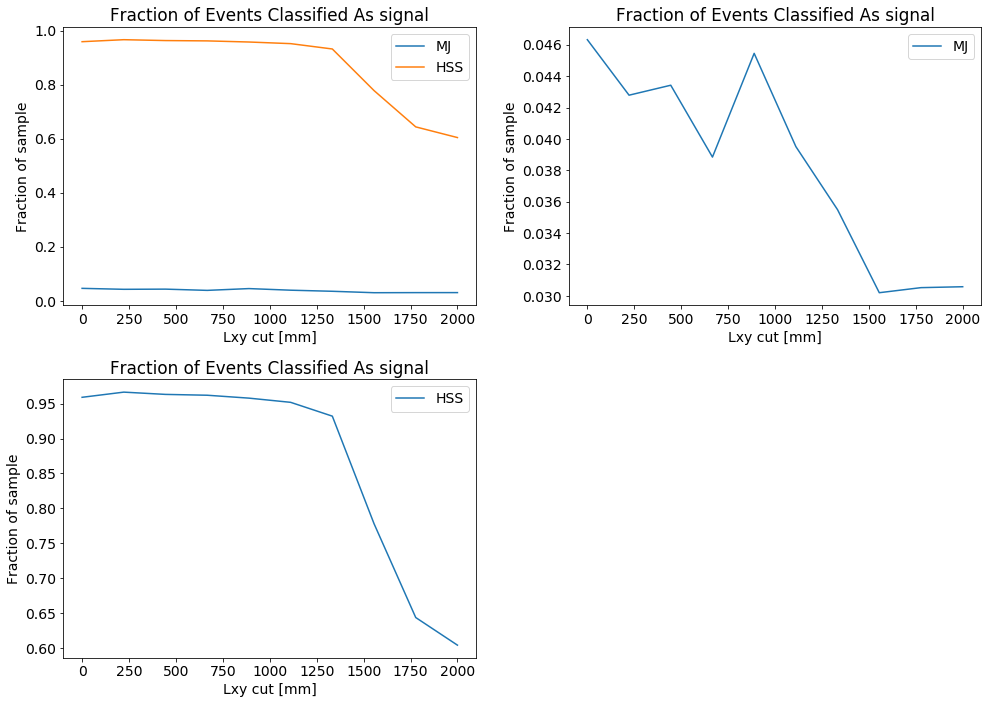

In [33]:
fig = plt.figure(figsize=(14,10))

ax = plt.subplot(221)
ax.plot(rBoth.T.cut_Lxy, rBoth.T.MJinHSS/rBoth.T.MJTotalWeight, label='MJ')
ax.plot(rBoth.T.cut_Lxy, rBoth.T.HSSinHSS/rBoth.T.HSSTotalWeight, label='HSS')
ax.set_xlabel("Lxy cut [mm]")
ax.set_ylabel("Fraction of sample")
ax.set_title("Fraction of Events Classified As signal")
ax.legend()

ax = plt.subplot(222)
ax.plot(rBoth.T.cut_Lxy, rBoth.T.MJinHSS/rBoth.T.MJTotalWeight, label='MJ')
ax.set_xlabel("Lxy cut [mm]")
ax.set_ylabel("Fraction of sample")
ax.set_title("Fraction of Events Classified As signal")
ax.legend()

ax = plt.subplot(223)
ax.plot(rBoth.T.cut_Lxy, rBoth.T.HSSinHSS/rBoth.T.HSSTotalWeight, label='HSS')
ax.set_xlabel("Lxy cut [mm]")
ax.set_ylabel("Fraction of sample")
ax.set_title("Fraction of Events Classified As signal")
ax.legend()

fig.tight_layout()
plt.show()

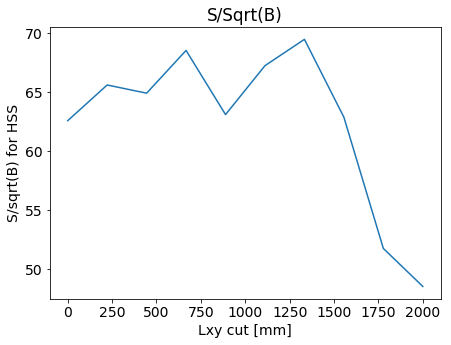

In [34]:
fig = plt.figure(figsize=(7,5))
ax = plt.subplot(111)
ax.plot(rBoth.T.cut_Lxy, rBoth.T.HSSSsqrtB)
ax.set_xlabel("Lxy cut [mm]")
ax.set_ylabel("S/sqrt(B) for HSS")
ax.set_title("S/Sqrt(B)")
plt.show()

From this, it looks like signal eff starts getting lost around 1250, so, if we were to keep signal constant, we'd want to tap out around there. s/sqrt(b) looks like it starts to drop around 1500. 

Is there any difference when we look at just the Lz cut?

In [20]:
%%time
rLz = scan_cuts((1250, 1250), (2000, 4000), all_events, steps=10)

Wall time: 1h 40min 5s


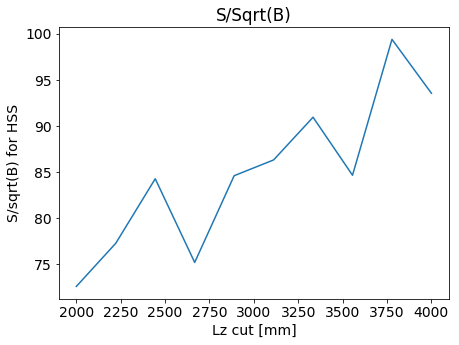

In [41]:
fig = plt.figure(figsize=(7,5))
ax = plt.subplot(111)
ax.plot(rLz.T.cut_Lz, rLz.T.HSSSsqrtB)
ax.set_xlabel("Lz cut [mm]")
ax.set_ylabel("S/sqrt(B) for HSS")
ax.set_title("S/Sqrt(B)")
plt.show()

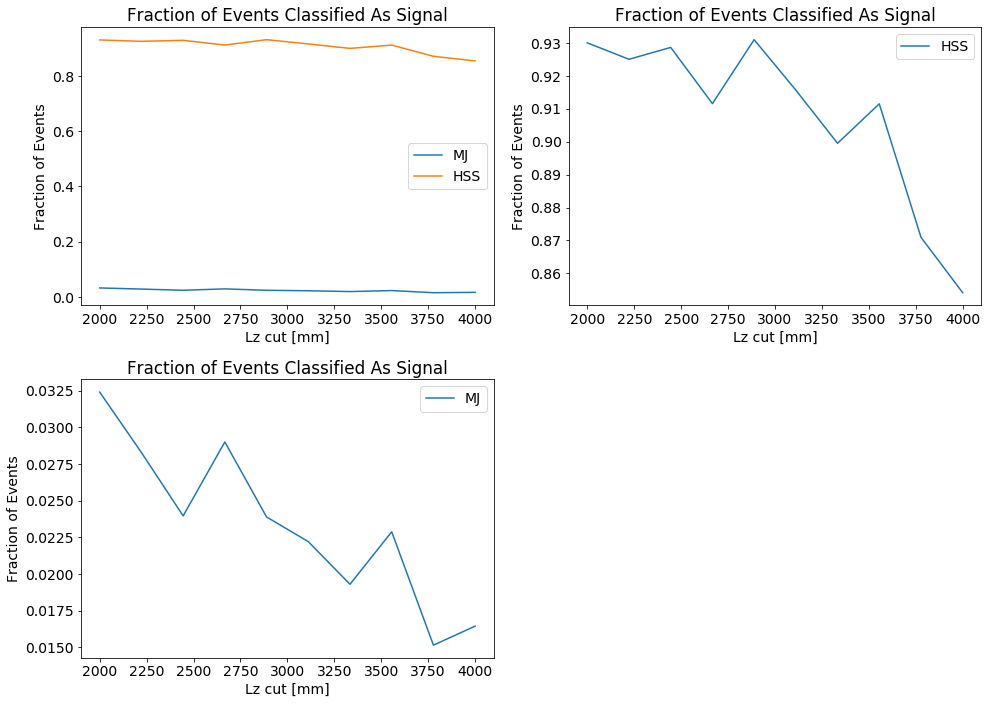

In [39]:
fig = plt.figure(figsize=(14,10))

ax = plt.subplot(221)
ax.plot(rLz.T.cut_Lz, rLz.T.MJinHSS/rLz.T.MJTotalWeight, label='MJ')
ax.plot(rLz.T.cut_Lz, rLz.T.HSSinHSS/rLz.T.HSSTotalWeight, label='HSS')
ax.set_xlabel("Lz cut [mm]")
ax.set_ylabel("Fraction of Events")
ax.set_title("Fraction of Events Classified As Signal")
ax.legend()

ax = plt.subplot(222)
ax.plot(rLz.T.cut_Lz, rLz.T.HSSinHSS/rLz.T.HSSTotalWeight, label='HSS')
ax.set_xlabel("Lz cut [mm]")
ax.set_ylabel("Fraction of Events")
ax.set_title("Fraction of Events Classified As Signal")
ax.legend()

ax = plt.subplot(223)
ax.plot(rLz.T.cut_Lz, rLz.T.MJinHSS/rLz.T.MJTotalWeight, label='MJ')
ax.set_xlabel("Lz cut [mm]")
ax.set_ylabel("Fraction of Events")
ax.set_title("Fraction of Events Classified As Signal")
ax.legend()

fig.tight_layout()
plt.show()

## Should we use eta as part of the training?

Eta could teach the network how to tell the difference between looking at the Lz and Lxy prediction - as we know that for forward jets one Lz is going to be more important than Lxy.

First, just do a training with and without.

In [12]:
rWithDLCutsAndEta = get_mj_weights(all_events[0], all_events[1], signal_default_cut, all_events[2], 
                                      training_list = default_training_variable_list + ['JetEta'])

In [15]:
result = {}
result["With Eta"] = rWithDLCutsAndEta
result["Default"] = rWithDLCuts
pd.DataFrame(result)

,Default,With Eta
BIBBack,6.605450e+07,6.381424e+07
BIBEff,6.493359e-01,6.526113e-01
BIBSsqrtB,1.061066e+01,1.084976e+01
BIBTotalCount,1.328080e+05,1.328080e+05
BIBTotalWeight,1.328080e+05,1.328080e+05
BIBinBIB,8.623700e+04,8.667200e+04
BIBinHSS,3.952000e+03,3.930000e+03
BIBinMJ,4.261900e+04,4.220600e+04
HSSBack,3.138381e+06,4.665195e+06
HSSEff,8.921889e-01,8.895916e-01
